In [2]:

# We have two models available:
# 1. ChessBot_13: A 13-channel chess bot model, which has an extra channel with the squares which pieces can go.
# 2. ChessBot: A standard chess bot model without the extra channel, only the pieces position.

# from model.Chessbot_Black_13Channel import ChessBot_13
# model = ChessBot_13()

# from  Chessbot_Black import ChessBot
from Chessbot_Black import ChessBot
model = ChessBot()

ChessBot initialized with model weights from: ./models/architecture_2Conv_classes/blackOnly/epoch-100.pth


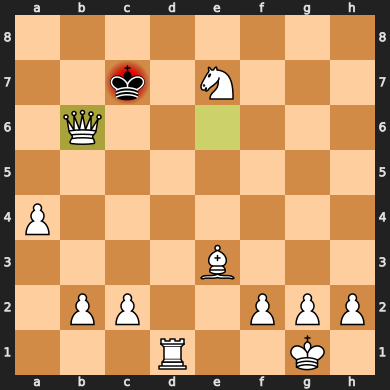

Played move:  g1g7 with probability:  0.0
Num of invalid moves played: 1925
Invalid moves: [('c7b6', np.float32(0.6419858)), ('c7d7', np.float32(0.28619963)), ('c7d6', np.float32(0.02788805)), ('c7b7', np.float32(0.026671536)), ('c7c6', np.float32(0.010019335)), ('c7c8', np.float32(0.0051441505)), ('c7b8', np.float32(0.0015908381)), ('c7d8', np.float32(0.00046790316)), ('a7b6', np.float32(2.2876346e-05)), ('b7b6', np.float32(3.609636e-06)), ('d8d7', np.float32(1.8240344e-06)), ('a6a5', np.float32(8.989345e-07)), ('d6d5', np.float32(4.921322e-07)), ('h6h5', np.float32(3.886735e-07)), ('a7a6', np.float32(3.5963427e-07)), ('f5g4', np.float32(3.017861e-07)), ('c7c5', np.float32(2.2680466e-07)), ('c4c3', np.float32(1.5907378e-07)), ('f6f5', np.float32(1.341929e-07)), ('b4c3', np.float32(9.737496e-08)), ('b3b2', np.float32(9.4034064e-08)), ('a6b7', np.float32(8.411171e-08)), ('e6d7', np.float32(8.2712965e-08)), ('c8d7', np.float32(7.0104456e-08)), ('c5b6', np.float32(6.615113e-08)), ('b7b5',

In [3]:
import numpy as np
from IPython.display import clear_output
import chess

board = chess.Board()

probs = np.zeros((8, 8))
display(board)


while not board.is_game_over():
    user_move = input("Your move (e.g., e2e4): ")
    if user_move == "exit":
        break
    try:
        board.push_san(user_move)
    except Exception as e:
        print("Invalid move. Try again.")
        continue

    best_moves = model.get_best_moves(board)
    invalid = 0
    invalid_moves = []
    for move in best_moves:
        try:
            board.push_uci(move[0])
            break
        except:
            invalid_moves.append(move)
            invalid+=1
            continue
    clear_output(wait=True)
    display(board)

    print(f"Played move: ", move[0], f"with probability: ", move[1]*100)
    print(f"Num of invalid moves played: {invalid}")
    print(f"Invalid moves: {invalid_moves}")
    